# Online Portfolio Selection

- **Introduction**

    Online portfolio selection is a prominent area in computational finance that focuses on the dynamic and strategic allocation of financial assets in a portfolio over time, utilizing real-time financial market data. This field stands at the intersection of various disciplines, including finance, statistics, artificial intelligence, machine learning, and data mining. It's characterized by its continuous adaptation to changing market conditions, aiming to optimize returns and minimize risks.

    The core challenge in online portfolio selection is to make sequential investment decisions that can adaptively respond to market fluctuations. Unlike traditional portfolio management, which often relies on historical data and static asset allocation strategies, online portfolio selection emphasizes real-time decision-making, leveraging computational algorithms and machine learning techniques to predict and react to market trends.

- **Goal**

    Study various online portfolio algorithm, focusing particularly on Cover's Universal Portfolio (UP) and the Exponentiated Gradient (EG), and apply them to historical data. Conclude by backtesting these strategies.

In [121]:
import cvxpy as cp
import numpy as np
import seaborn as sns
import matplotlib as plt
import yfinance as yf
import pandas as pd
import string
import random

## Dataset details
- stock name
- start date
- end date
- $T$ = trading days between end and start date


In [122]:
#choose the stocks here
benchmark_asset = ['^GSPC']
benchmark_asset_name = ['S&P500']
assets = ['META','AAPL','GOOG','V','NFLX','AMZN','MSFT','JNJ','BAC','BA']
asset_name = ['META','AAPL','GOOG','V','NFLX','AMZN','MSFT','JNJ','BAC','BA']

#choose the peroid of the investment
start="2013-01-01"
end="2023-01-01"

assets.sort()
asset_name.sort()

### Stock datas
- This class is for the data of individual stock
- transform the data into a matrix form

Suppose we have $n$ stocks, and investiment period for $t$ days, then we have the following price relative matrix:

$$
\begin{pmatrix}
r_{11} & r_{21} & r_{31} & \cdots & r_{n1} \\
r_{12} & r_{22} & r_{32} & \cdots & r_{n2} \\
\vdots & \vdots & \vdots & \ddots & \cdots \\
r_{1t} & r_{2t} & r_{3t} & \cdots & r_{nt}
\end{pmatrix}
$$

The entry $r_{ij}$ means the price relative of the $i$-th stock at day $j$.

For convenience, we write:

$$
{\bf r}^{(t)} = \begin{pmatrix} r_{1t} & r_{2t} & \cdots & r_{nt} \end{pmatrix}
$$

which means the price relative vector of day $t$.

Thus we may regard the matrix as:

$$
\begin{pmatrix}
r_{11} & r_{21} & r_{31} & \cdots & r_{n1} \\
r_{12} & r_{22} & r_{32} & \cdots & r_{n2} \\
\vdots & \vdots & \vdots & \ddots & \cdots \\
r_{1t} & r_{2t} & r_{3t} & \cdots & r_{nt}
\end{pmatrix}
=
\begin{pmatrix}
{\bf r}^{(1)} \\
{\bf r}^{(2)} \\
{\bf r}^{(3)} \\
\vdots \\
{\bf r}^{(t)}
\end{pmatrix}
$$




By similar arguments, we can obtain a weight matrix:

$$
\begin{pmatrix}
x_{11} & x_{21} & x_{31} & \cdots & x_{n1} \\
x_{12} & x_{22} & x_{32} & \cdots & x_{n2} \\
\vdots & \vdots & \vdots & \ddots & \cdots \\
x_{1t} & x_{2t} & x_{3t} & \cdots & x_{nt}
\end{pmatrix}
=
\begin{pmatrix}
{\bf x}^{(1)} \\
{\bf x}^{(2)} \\
{\bf x}^{(3)} \\
\vdots \\
{\bf x}^{(t)}
\end{pmatrix}
$$

The entry $x_{ij}$ means the weight of the $i$-th stock at day $j$, and we have the weight vector of day $t$.

$$
\bf{x}^{(t)} =
\begin{pmatrix}
x_{1t} & x_{2t} & \cdots & x_{nt}
\end{pmatrix}
$$

$\text{where} \sum_{i=1}^n x_{ij} = 1, \quad 0 \leq x_{ij} \leq 1, \quad \text{for all } j = 1, \ldots, t$


Having the price relative sequence $\{{\bf r}^{(i)}\}$ and weight sequence $\{{\bf x}^{(i)}\}$, we can compute the return of investment.

The return of investment from day $1$ to day $t$ is given by:

$$
W_{t}(\{{\bf r}^{(i)}\},\{{\bf x}^{(i)}\}) = \prod^{t}_{i=1} {\bf r}^{(i)} \cdot {\bf x}^{(i)}
$$

In [123]:
# Downloading data
data = yf.download(assets+benchmark_asset, start = start, end = end)
data = data.loc[:,('Adj Close', slice(None))]
data.columns = asset_name+benchmark_asset_name
print(data)

# fill NAN
data.ffill()
for n in asset_name+benchmark_asset_name:
    data[n].fillna(method ='ffill',inplace = True)

# calculate the price relative
df = 1+data[asset_name+benchmark_asset_name].pct_change().dropna()
r = df[asset_name].to_numpy()
df = df.cumprod(axis=0)
print(df)

[**********************64%******                 ]  7 of 11 completed

[*********************100%***********************]  11 of 11 completed
                  AAPL       AMZN          BA        BAC       GOOG  \
Date                                                                  
2013-01-02   16.769091  12.865500   64.583832   9.913475  18.013729   
2013-01-03   16.557423  12.924000   64.919067   9.855790  18.024191   
2013-01-04   16.096228  12.957500   65.103401   9.979399  18.380356   
2013-01-07   16.001543  13.423000   63.796135   9.962918  18.300158   
2013-01-08   16.044609  13.319000   62.120159   9.872275  18.264042   
...                ...        ...         ...        ...        ...   
2022-12-23  131.127075  85.250000  189.059998  31.489532  89.809998   
2022-12-27  129.307236  83.040001  189.399994  31.547718  87.930000   
2022-12-28  125.339409  81.820000  188.380005  31.780474  86.459999   
2022-12-29  128.889572  84.180000  188.910004  32.139297  88.949997   
2022-12-30  129.207779  84.000000  190.490005  32.119904  88.730003   

     

Text(0, 0.5, 'log return')

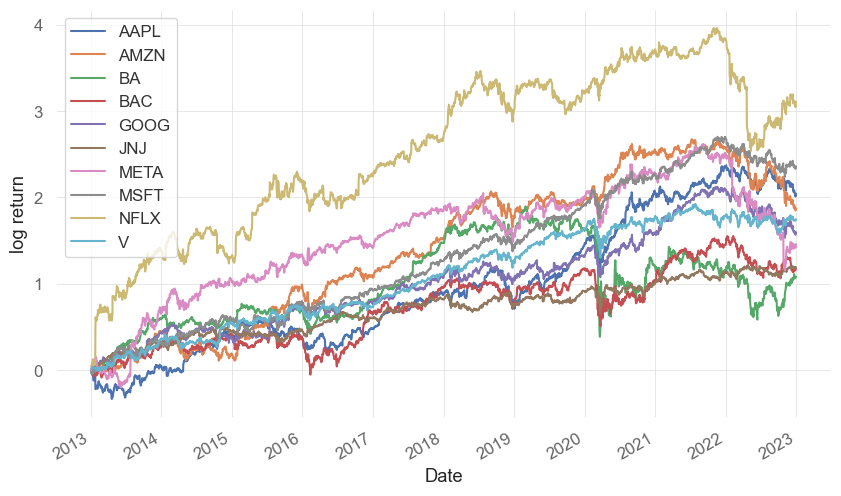

In [124]:
ax = np.log(df[asset_name]).plot()
ax.set_ylabel("log return")

In [125]:
# calculate the return with commission
def pay_fee_period(r,weight,period,buy_fee = 0.001425,sell_fee = 0.001425+0.003):
  '''input:  r : related prices
     weight: weight metrix
     period: rebalence period
    output: result -> np_array shape(T*1) '''
  t = 0
  fee = (buy_fee+sell_fee)/2
  result = np.zeros(r.shape[0])
  result[0] = np.dot(r[0],weight[0])
  now = r[0]*weight[0]
  now = now/sum(now)
  t+=1
  for i in range(1,period):
    now = now*r[t]
    result[t] = sum(now)
    now = now/sum(now)
    t+=1
  for i in range(1,weight.shape[0]-1):
    x = weight[i]
    diff_val = np.linalg.norm(now-x,1)*fee
    x = x-(weight[i]*diff_val)
    now = r[i]*x
    result[t] = sum(now)
    now=now/sum(now)
    t+=1
    for j in range(1,period):
      now = now*r[t]
      result[t] = sum(now)
      now = now/sum(now)
      t+=1
  for i in range(t,r.shape[0]):
    now = now*r[i]
    result[i] = sum(now)
    now = now/sum(now)
  return result

## Buy and Hold (B&H)

Buy and Hold ($\text{B\&H}$) strategy is to buy the stocks at day $1$ and sell them at day $T$.

Here we choose the equal weight $\mathbf{x} = \begin{pmatrix} \frac{1}{n} & \frac{1}{n} & \cdots & \frac{1}{n} \end{pmatrix}$.

- **Advantages**

    - Reduced Costs:

        No rebalance cost.
        
- **Disadvantages**

    -  Market Risk:

        While the market generally trends upwards over the long term, there are no guarantees, and there can be prolonged periods of stagnation or decline.

In [126]:
class BAH:
  def __init__(self, r):
    '''r = 'return' (T*n np_matrix)
      weight = weight for every days and every stocks (T*n np_matrix)'''
    self.r = r
    self.t = 0
    self.n = r.shape[1]
    self.weight = np.zeros((r.shape[0],self.n))
    self.period = 1
    self.name = 'BAH'
  def run(self):
    self.weight[0] = np.ones(r.shape[1])/r.shape[1]
    for time in range(1,self.r.shape[0]):
      x = self.r[time]*self.weight[self.t]
      self.weight[time] = x/sum(x)
      self.t+=1
    return

Text(0, 0.5, 'log return')

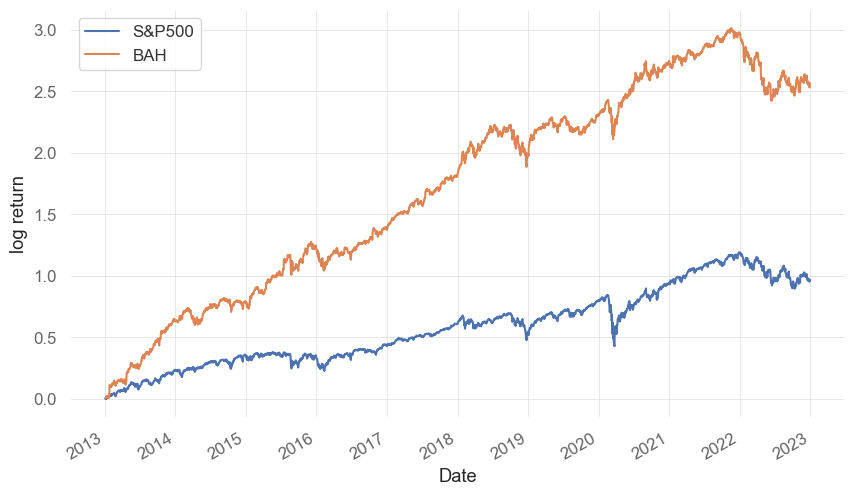

In [127]:
bah = BAH(r)
bah.run()
df['BAH'] = np.cumprod(np.sum(np.multiply(r,bah.weight), axis=1))
ax = np.log(df[benchmark_asset_name+['BAH']]).plot()
ax.set_ylabel("log return")

## Constant Rebalanced Portfolio (CRP)

The Constant Rebalanced Portfolio ($\text{CRP}$) is an investment strategy focused on maintaining a fixed weight of different assets in a portfolio, i.e.

$$
{\bf x} = {\bf x}^{(1)} = {\bf x}^{(2)} = \cdots = {\bf x}^{(n)}
$$

- **Strategy Mechanics**

  - Buy Low, Sell High
  
      The strategy involves purchasing those assets when the prices are low and then selling them when the market stabilizes or asset prices increase.
            
  - Rebalancing
  
      Regular portfolio rebalancing is essential to manage risks and maintain desired asset allocations.

- **Special cases of $\text{CRP}$**

    - Uniform Constant Rebalanced Portfolio ($\text{UCRP}$):

        Each stock is equally weighted, i.e.

        $$
        {\bf x} = \begin{pmatrix} \frac{1}{n} & \frac{1}{n} & \cdots & \frac{1}{n} \end{pmatrix}
        $$

    - Best Constant Rebalanced Portfolio ($\text{BCRP}$):

        Find a weight vector such that the return is maximized, i.e.

        $$
        {\bf x}^{*} = \arg\max_{{\bf x} \in \Delta_{n}}\{\prod_{i=1}^T {\bf r}^{(i)} \cdot {\bf x}\}
        $$

        where $\Delta_{n} = \{{\bf x} \in \mathbb{R}^n | \sum_{i=1}^n x_{i}=1 , 0 \leq x_{i} \leq 1 \}$

        Note that $\text{BCRP}$ strategy requires the knowledgement of future.

- **Advantages**

    - Risk Control:
        
        Maintains a consistent risk profile by ensuring that the asset allocation doesn’t drift over time.

    - Volatility Harvesting

       An investment strategy that involves regularly rebalancing a diversified portfolio to exploit the natural fluctuations in asset prices.

- **Disadvantages**

    - Transaction Costs:

        Frequent rebalancing can incur transaction fees and taxes, which might impact overall returns.

    - Not Optimized for Short-Term:

        $\text{CRP}$ is generally more suited for long-term investing, as short-term market fluctuations are less relevant to the strategy.


In [128]:
class UCRP():
    def __init__(self, r,period = 1):
        # r is the price relative matrix
        self.r = r
        self.weight = np.ones((r.shape[0]//period,r.shape[1]))/r.shape[1]
        self.period = period
        self.name = 'UCRP'

Text(0, 0.5, 'log return')

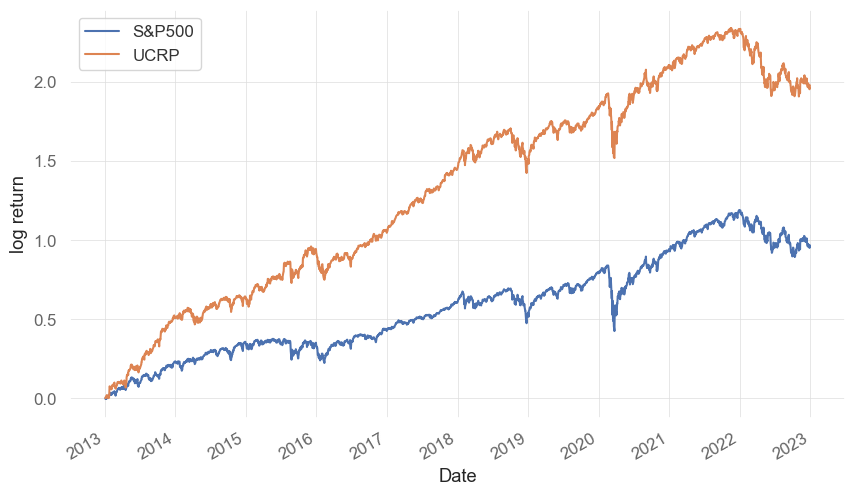

In [129]:
ucrp = UCRP(r)
df['UCRP'] = np.cumprod(pay_fee_period(r,ucrp.weight,ucrp.period))
ax = np.log(df[benchmark_asset_name+['UCRP']]).plot()
ax.set_ylabel("log return")

In [130]:
class BCRP:
  def __init__(self, r):
    '''r = 'return' (T*n np_matrix)
      weight = weight for every days and every stocks (T*n np_matrix)'''
    self.r = r
    self.n = r.shape[1]
    self.weight = np.zeros((r.shape[0],self.n))
    self.period = 1
    self.name = 'BCRP'
  def bcrp(self,T):
    if T == range(0):
      return np.ones(self.n)/self.n

    x = cp.Variable(self.n)

    obj = cp.sum(cp.log(self.r[T]@x))
    prob = cp.Problem(cp.Maximize(obj), [cp.sum(x) == 1, x >= 0])
    prob.solve()
    return x.value
  def run(self):
    x = self.bcrp(range(r.shape[0]))
    for i in range(r.shape[0]):
      self.weight[i] = x
    return

Text(0, 0.5, 'log return')

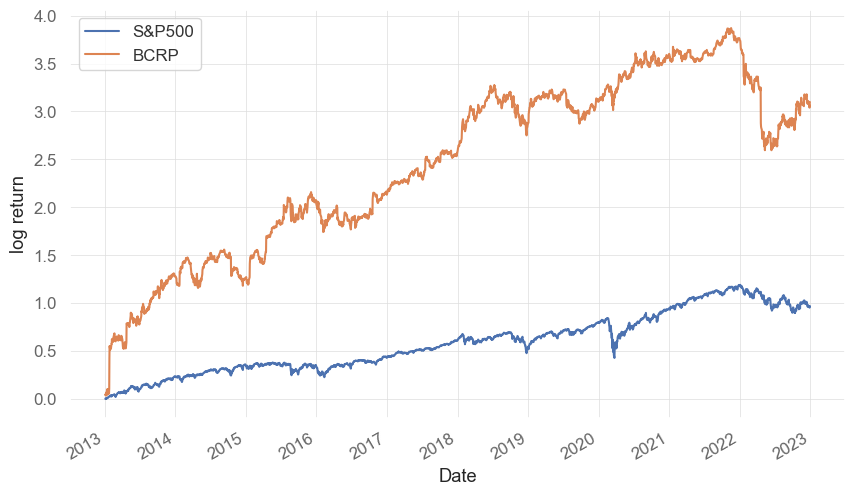

In [131]:
bcrp = BCRP(r)
bcrp.run()
df['BCRP'] = np.cumprod(pay_fee_period(r,bcrp.weight,1))
ax = np.log(df[benchmark_asset_name+['BCRP']]).plot()
ax.set_ylabel("log return")

## Follow The Leader (FTL)

Follow The Leader ($\text{FTL}$) strategy is that the weight vector of day $t$ is equal to the BEST performed portfolio from day $1$ to day $t-1$

The BEST performed portfolio is chosen by $\text{BCRP}$, i.e.

$$
\begin{align*}
{\bf x}^{(t)} &= \arg\max_{{\bf x} \in \Delta_{n}}\{\prod_{i=1}^{t-1} {\bf r}^{(i)} \cdot {\bf x}\} \quad \forall t \geq 2
\\
{\bf x}^{(1)} &=
\begin{pmatrix}
\frac{1}{n} & \frac{1}{n} & \cdots & \frac{1}{n}
\end{pmatrix}
\end{align*}
$$

- **Advantages**

    - Naive approach to high return:
        
        If the leaders are consistently successful, following their lead could potentially result in high returns.

- **Disadvantages**

    - Incomplete Information:
    
        Public disclosures and media reports may not provide a complete picture of an investment strategy. Leaders might have complex strategies that aren't fully visible or understandable to outsiders.

In [132]:
# datarange = 100days, for convinient，assume the weight vector today only depends on privious 100 days
class FTL(BCRP):
  def __init__(self, r):
    '''r = 'return' (T*n np_matrix)
      weight = weight for every days and every stocks (T*n np_matrix)
      period: rebalence period
      datarange = number of day in order to determine weight of last day'''
    self.r = r
    self.n = r.shape[1]
    self.weight = np.zeros((r.shape[0],self.n))
    self.datarange = 100
    self.period = 1
    self.name = 'FTL'
  def run(self):
    for time in range(self.r.shape[0]):
      if time<self.datarange:
        x = super().bcrp(range(time))
      else:
        x = super().bcrp(range(time-self.datarange,time))
      self.weight[time] = x
    return

Text(0, 0.5, 'log return')

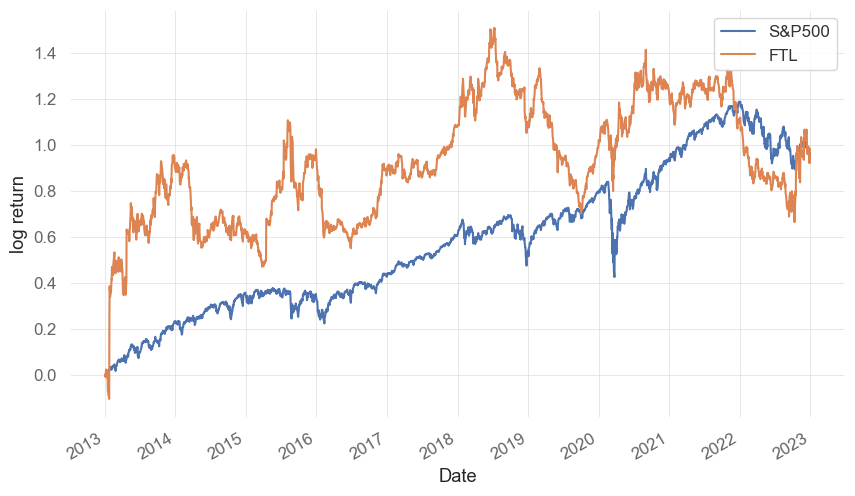

In [133]:
ftl = FTL(r)
ftl.run()
df['FTL'] = np.cumprod(pay_fee_period(r,ftl.weight,1))
ax = np.log(df[benchmark_asset_name+['FTL']]).plot()
ax.set_ylabel("log return")

## Universal Portfolio (UP)

First, for each weight vector ${\bf x} \in \Delta_{n}$, we consider:

$$
W_{t-1}({\bf x})=\prod_{i=1}^{t-1} {\bf r}^{(i)} \cdot {\bf x} \quad \forall t \geq 2
$$

which means we assign a higher weight if the performance of the portfolio is better.

Second, weight vector of day $t$ using the $\text{UP}$ strategy is the function given by:
$$
{\bf x}^{(t)}=
\frac{\int_{{\bf x} \in \Delta_{n}} {\bf x} \cdot W_{t-1}({\bf x})d \mu ({\bf x})}{\int_{{\bf x} \in \Delta_{n}}W_{t-1}({\bf x})d \mu ({\bf x})} \quad \forall t \geq 2
$$

The initial weight vector is given by:

$$
{\bf x}^{(1)}=
\begin{pmatrix}
\frac{1}{n}&
\frac{1}{n}&
\cdots&
\frac{1}{n}
\end{pmatrix}
$$

where $\mu$ is the uniform distribution or dirichlet distribution over $n$-simplex $\Delta_{n}$.

- **Advantages**

    - Theoretical Foundation:
    
        The strategy is grounded in solid mathematical theory, which ensure the worst case performance would not going too bad

- **Disadvantages**

    - Complexity:
    
        Requires sophisticated algorithms and often extensive computational resources.


### Analysis of UP

We only porve the case when $\mu({\bf x})$ is uniform distribution
- **Definition**

    Let $\{{\bf x^{(i)}}\}$ be a weight sequence, and ${\bf x^{*}}$ be the weight vector choosen by $\text{BCRP}$, then we define the Regret of $\{{\bf x^{(i)}}\}$ compared to ${\bf x^{*}}$ by:

    $$
    R_T(\{{\bf r^{(i)}}\},\{{\bf x^{(i)}}\})=\log{W_T}(\{{\bf r}^{(i)}\},\{{\bf x}^{*}\})-\log{W_T}(\{{\bf r}^{(i)}\},\{{\bf x}^{(i)}\})
    $$

- **THEOREM**

  If we choose $\mu({\bf x})$ as uniform distribution, and let $\{\hat{\bf x}^{(i)}\}$ be the weight sequence obtain from $UP$ algoritm, then:

  $$
  R_T(\{{\bf r^{(i)}}\},\{{\bf \hat{x}^{(i)}}\}) \leq (n-1)\log(T+1)
  $$

  where $T$ is the time of investment and $n$ is the number of stocks.

  The above theorem says that the Regret of $\text{UP}$ is bounded by $(n-1)\log(T+1)$.

- **Proof:**

  **Settings:**

  Let $\{{\bf u}\}$ be the weight sequence choosen by $\text{CRP}$ strategy, where ${\bf u} \in \Delta_{n}$.

  We denote $\{{\bf x}^{*}\}$ as the weight sequence choosen by $\text{BCRP}$ strategy, where ${\bf x}^{*} \in \Delta_{n}$.

  **Idea:**

  The idea behind our argument is that portfolios “near” to each other perform similarly and that a large fraction of portfolios are “near” the optimal portfolio.

  Here is what we mean when we say that “near” portfolios ${\bf x}$ perform nearly as well as ${\bf x}^{*}$:

  ${\bf x} = (1-\alpha){\bf x}^{*} + \alpha{\bf w}$ for some ${\bf w} \in \Delta_{n}$

  **Step 1:**

  First, from the $\text{UP}$ algorithm, we can directly obtain:

  $$
  \begin{align*}
  W(\{{\bf r}^{(i)}\},\{\hat{\bf x}^{(i)}\})&=\prod^{t}_{i=1} {\bf r}^{(i)} \cdot \hat{{\bf x}}^{(i)}
  \\
  &= \prod^{t}_{i=1} \frac{\int_{{\bf x} \in \Delta_{n}} {\bf r}^{(i)} \cdot {\bf x} \cdot W_{i-1}({\bf x})d \mu ({\bf x})}{\int_{{\bf x} \in \Delta_{n}}W_{i-1}({\bf x})d \mu ({\bf x})}
  \\
  &= \prod^{t}_{i=1} \frac{\int_{{\bf x} \in \Delta_{n}} W_{i}({\bf x})d \mu ({\bf x})}{\int_{{\bf x} \in \Delta_{n}} W_{i-1}({\bf x})d \mu ({\bf x})}
  \\
  &=\frac{\int_{{\bf x} \in \Delta_{n}} \prod^{t}_{i=1} W_{i}({\bf x})d \mu ({\bf x})}{\int_{{\bf x} \in \Delta_{n}} \prod^{t}_{i=1} W_{i-1}({\bf x})d \mu ({\bf x})}
  \\
  &= \frac{\int_{{\bf x} \in \Delta_{n}} W_{t}({\bf x})d \mu ({\bf x})}{\int_{{\bf x} \in \Delta_{n}} 1 \, d \mu ({\bf x})}
  \\
  &= \mathbb{E}_{{\bf x} \in \Delta_{n}}[{W}(\{{\bf r}^{(i)}\},\{{\bf x}\})]
  \end{align*}
  $$

  Hence

  $$
  {W}(\{{\bf r}^{(i)}\},\{\hat{\bf x}^{(i)}\})={\mathbb E}_{{\bf x} \in \Delta_{n}}[{W}(\{{\bf r}^{(i)}\},\{{\bf x}\})] \quad \tag{\text{1}}
  $$

  Second, consider ${\bf x} = (1-\alpha){\bf x}^{*} + \alpha{\bf w}$, for some ${\bf w} \in \Delta_{n}$ we have:

  $$
  \text{Single period's} \, {W}(\{{\bf r}^{(i)}\},\{{\bf x}\}) \geq (1-\alpha) \, \text{Single period's} \, {W}(\{{\bf r}^{(i)}\},\{{\bf x}^{*}\})
  $$

  After all, compiled over $T$ periods, we obtain:

  $$
  {W}(\{{\bf r}^{(i)}\},\{{\bf x}\}) \geq (1-\alpha)^{T} \, {W}(\{{\bf r}^{(i)}\},\{{\bf x}^{*}\}) \quad \tag{\text{2}}
  $$

  Third, we will show that a sufficiently large volume of portfolios is sufficiently near ${\bf x}^{*}$.

  Note that the $n$-simplex is $(n-1)$-dimensional, hence we have:

  $$
  \text{Vol}_{n-1}(\{(1-\beta){\bf x}^{*}+\beta{\bf z} | {\bf z} \in \Delta_{n}\}) = \text{Vol}_{n-1}(\{\beta{\bf z} | {\bf z} \in \Delta_{n}\}) = \beta^{n-1} \text{Vol}_{n-1}(\Delta_{n}) \quad \tag{\text{3}}
  $$

  and we have $\{(1-\beta){\bf x}^{*}+\beta{\bf z} | {\bf z} \in \Delta_{n}\} = \text{Vol}_{n-1}\{\beta{\bf z} | {\bf z} \in \Delta_{n}\} \subset \Delta_{n}$

  **Step 2:**

  If we consider $\alpha$ as a random variable defined by $1-\alpha = \underset{j}{min} \{\frac{{\bf x}_{j}}{{\bf x}^{*}_{j}}\}$, then from $(1)$ and $(2)$ in Step $1$ we have:

  $$
  \frac{{W}(\{{\bf r}^{(i)}\},\{\hat{\bf x}^{(i)}\})}{{W}(\{{\bf r}^{(i)}\},\{{\bf x}^{*}\})} \geq \frac{\mathbb{E}_{{\bf z} \in \Delta_{n}}[{W}(\{{\bf r}^{(i)}\},\{{\bf z}\})]}{(1-\alpha)^{-T} {W}(\{{\bf r}^{(i)}\},\{{\bf x}^{*}\})} = \mathbb{E}_{{\bf z} \in \Delta_{n}}\left[(1-\alpha)^{T}\right] = \int^{1}_{0} \text{Prob}_{{\bf z} \in \Delta_{n}}\left[(1-\alpha)^{T} \geq x\right]dx
  $$

  **Step 3:**

  By $(3)$

  choosing a point ${\bf z} \in \Delta_{n}$, such that $\alpha = 1-\underset{j}{min}\{\frac{z_{j}}{z^{*}_{j}}\} \geq 1-x^{\frac{1}{T}}$, means ${\bf z} \in \{(1-\beta){\bf x}^{*}+\beta{\bf z} | {\bf z} \in \Delta_{n}\} \subset \Delta_{n}$ 
  
  where $\beta=1-x^{\frac{1}{T}}$

  $$
  \text{Prob}_{{\bf z} \in \Delta_{n}}\left[(1-\alpha)^{T} \geq x\right] = \text{Prob}_{{\bf z} \in \Delta_{n}}\left[1-x^{\frac{1}{T}} \leq \alpha \right] = (1-x^{\frac{1}{T}})^{n-1}
  $$

  hence:

  $$
  \frac{{W}(\{{\bf r}^{(i)}\},\{\hat{\bf x}^{(i)}\})}{{W}(\{{\bf r}^{(i)}\},\{{\bf x}^{*}\})} \geq \int^{1}_{0} \text{Prob}_{{\bf z} \in \Delta_{n}}\left[(1-\alpha)^{T} \geq x\right]dx = \int^{1}_{0} (1-x^{\frac{1}{T}})^{n-1} dx
  $$

  Let $y = x^{\frac{1}{T}}$ and repeating integration by parts, this yields:

  $$
  \begin{align*}
  \int^{1}_{0} (1-x^{\frac{1}{T}})^{n-1} dx &= T\left(\int^{1}_{0} y^{T-1}(1-y)^{n-1} dy\right)
  \\
  &= T\left(\frac{n-1}{T} \int^{1}_{0} y^{T}(1-y)^{n-2} dy\right)
  \\
  &= T\left(\frac{n-1}{T} \frac{n-2}{T+1} \int^{1}_{0} y^{T+1}(1-y)^{n-3} dy\right)
  \\
  & \cdots
  \\
  &= T\left(\frac{(n-1)!(T-1)!}{(T+n-2)!} \int^{1}_{0} y^{T+n-2} dy\right)
  \\
  &= \begin{pmatrix} T+n-1 \\ n-1 \end{pmatrix}^{-1}
  \end{align*}
  $$

  Thus we have:

  $$
  \begin{align*}
  \frac{{W}(\{{\bf r}^{(i)}\},\{{\bf x}^{*}\})}{{W}(\{{\bf r}^{(i)}\},\{\hat{\bf x}^{(i)}\})} &\leq
  \begin{pmatrix}
  T+n-1 \\
  n-1
  \end{pmatrix}
  \leq (T+1)^{n-1}
  \\
   
  \\
  \log\frac{{W}(\{{\bf r}^{(i)}\},\{{\bf x}^{*}\})}{{W}(\{{\bf r}^{(i)}\},\{\hat{\bf x}^{(i)}\})} &= \log{W}(\{{\bf r}^{(i)}\},\{{\bf x}^{*}\})-\log{W}(\{{\bf r}^{(i)}\},\{\hat{\bf x}^{(i)}\})
  \\
  &= R_T(\{{\bf \hat{x}^{(i)}}\},\{{\bf r^{(i)}}\})
  \\
  &\leq (n-1)\log(T+1) \quad \Box
  \end{align*}
  $$
  
- **Corollary:**

  $$
  \lim_{T \to \infty} \frac{1}{T} \underset{\{{\bf r}^{(i)}\}}{\max}\{R_T(\{{\bf \hat{x}^{(i)}}\},\{{\bf r^{(i)}}\})\} \leq 0
  $$

  That is, $\text{UP}$ algorithm exhibits the same asymptotic growth rate in normalized logrithmic return as the $\text{BCRP}$ for any sequence of price relatives $\{{\bf r}^{(i)}\}$.

  - **proof**

    By Theorem, we have:

    $$
    R_T(\{{\bf \hat{x}^{(i)}}\},\{{\bf r^{(i)}}\})=\log{W}(\{{\bf r}^{(i)}\},\{{\bf x}^{*}\})-\log{W}(\{{\bf r}^{(i)}\},\{\hat{\bf x}^{(i)}\}) \leq (n-1)\log(T+1)
    $$

    for any price relative sequence $\{{\bf r}^{(i)}\}$

    which implies:

    $$
    \underset{\{{\bf r}^{(i)}\}}{\max}\{\log{W}(\{{\bf r}^{(i)}\},\{{\bf x}^{*}\})-\log{W}(\{{\bf r}^{(i)}\},\{\hat{\bf x}^{(i)}\})\} \leq (n-1)\log(T+1)
    $$

    Divides both sides by T, we obtain:

    $$
    \frac{1}{T}\underset{\{{\bf r}^{(i)}\}}{\max}\{(\log{W}(\{{\bf r}^{(i)}\},\{{\bf x}^{*}\})-\log{W}(\{{\bf r}^{(i)}\},\{\hat{\bf x}^{(i)}\}))\} \leq \frac{(n-1)\log(T+1)
    }{T}
    $$

    Letting $T \to \infty$, and apply L'Hospital's Rule:
    
    $$
    \lim_{T \to \infty} \frac{1}{T}\underset{\{{\bf r}^{(i)}\}}{\max}\{(\log{W}(\{{\bf r}^{(i)}\},\{{\bf x}^{*}\})-\log{W}(\{{\bf r}^{(i)}\},\{\hat{\bf x}^{(i)}\}))\} \leq \lim_{T \to \infty}\frac{(n-1)\log(T+1)}{T}=\lim_{T \to \infty}\frac{n-1}{T+1}=0
    $$

    Namely:

    $$
    \lim_{T \to \infty} \frac{1}{T} \underset{\{{\bf r}^{(i)}\}}{\max}\{R_T(\{{\bf \hat{x}^{(i)}}\},\{{\bf r^{(i)}}\})\} \leq 0 \quad \Box
    $$

In [134]:
# use Monte Carlo method to estimate the result of integral
class UP_uniform:
  def __init__(self, r,period=1, eval_points=1e4):
    '''r = 'return' (T*n np_matrix)
      weight = weight for every days and every stocks (T*n np_matrix)
      period: rebalence period'''
    self.name = 'UP_uniform'
    self.eval_points = int(eval_points)
    self.period = period
    self.n = r.shape[1]
    self.t = 1
    self.weight = np.array([np.ones(r.shape[1])/r.shape[1]])
    self.r = np.zeros(((r.shape[0])//self.period,self.n))
    for i in range((r.shape[0])//self.period):
      temp = np.ones(self.n)
      for j in range(self.period):
        temp*=r[i*self.period + j]
      self.r[i] = temp

  def mc_simplex(self,d, points):
    """Sample random points from a simplex with dimension d.
    :param d: Number of dimensions.
    :param points: Total number of points.
    """
    a = np.sort(np.random.random((points, d)))
    a = np.hstack([np.zeros((points, 1)), a, np.ones((points, 1))])
    return np.diff(a)

  def init_step(self):
    """Create a mesh on simplex and keep wealth of all strategies."""
    # create set of CRPs
    self.W = np.matrix(self.mc_simplex(self.n-1, self.eval_points))
    self.S = np.matrix(np.ones(self.W.shape[0])).T


  def step(self):
    # calculate new wealth of all CRPs
    self.S = np.multiply(self.S, self.W * np.matrix(self.r[self.t]).T)
    b = self.W.T * self.S
    self.t+=1
    return b / sum(b)

  def run(self):
    self.init_step()
    for i in range(self.r.shape[0]-1):
      arr = self.step().T
      self.weight = np.vstack((self.weight,arr))
    self.weight = np.array(self.weight)
    return

In [135]:
from scipy.stats import dirichlet
class UP_dirichlet:
  def __init__(self, r,period = 1, eval_points=1e4):
    '''r = 'return' (T*n np_matrix)
      weight = weight for every days and every stocks (T*n np_matrix)
      period: rebalence period'''
    self.name = 'UP_dirichlet'
    self.n = r.shape[1]
    self.alpha = np.ones(self.n)/2
    self.eval_points = int(eval_points)
    self.period = period
    self.t = 1
    self.weight = np.array([np.ones(r.shape[1])/r.shape[1]])
    self.r = np.zeros(((r.shape[0])//self.period,self.n))
    for i in range((r.shape[0])//self.period):
      temp = np.ones(self.n)
      for j in range(self.period):
        temp*=r[i*self.period + j]
      self.r[i] = temp

  def mc_simplex(self,d, points):
    """Sample random points from a simplex with dimension d.
    :param d: Number of dimensions.
    :param points: Total number of points.
    """
    a = np.sort(np.random.random((points, d)))
    a = np.hstack([np.zeros((points, 1)), a, np.ones((points, 1))])
    return np.diff(a)

  def init_step(self):
    """Create a mesh on simplex and keep wealth of all strategies."""
    # create set of CRPs
    self.W = np.matrix(self.mc_simplex(self.n-1, self.eval_points))
    self.x = np.matrix([dirichlet.pdf(np.array(y)[0],self.alpha) for y in self.W]).T
    # self.W = np.multiply(self.W,x)
    self.S = np.matrix(np.ones(self.W.shape[0])).T


  def step(self):
    # calculate new wealth of all CRPs
    self.S = np.multiply(self.S, self.W * np.matrix(self.r[self.t]).T)
    b = np.multiply(self.W,self.x).T * self.S
    self.t+=1
    # print(self.S)
    return b / sum(b)

  def run(self):
    self.init_step()
    for i in range(self.r.shape[0]-1):
      arr = self.step().T
      self.weight = np.vstack((self.weight,arr))
    self.weight = np.array(self.weight)
    return


Text(0, 0.5, 'log return')

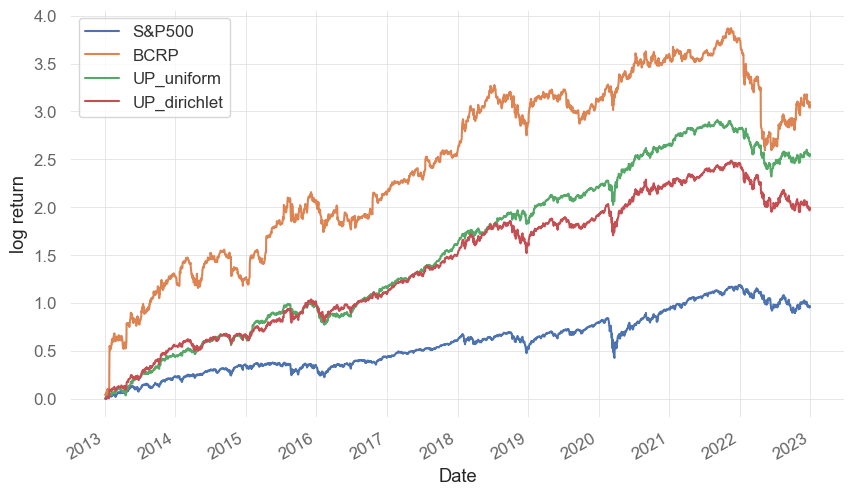

In [136]:
up_uniform = UP_uniform(r,7)
up_uniform.run()
df['UP_uniform'] = np.cumprod(pay_fee_period(r,up_uniform.weight,up_uniform.period))

up_dirichlet = UP_dirichlet(r,7)
up_dirichlet.run()
df['UP_dirichlet'] = np.cumprod(pay_fee_period(r,up_dirichlet.weight,1))

ax = np.log(df[benchmark_asset_name+['BCRP']+['UP_uniform','UP_dirichlet']]).plot()
ax.set_ylabel("log return")

## Exponentiated Gradient (EG)

In the linear regression setting, Kivinen and Warmuth show that good performance can be achieved by choosing a weight vector ${\bf x}^{(t+1)}$ that is "close" to ${\bf x}^{(t)}$, We adapt their method and find a new weight vector ${\bf x}^{(t+1)}$ that (approximately) maximizes the following function:

$$
F({\bf x}^{(t+1)})=\eta \log({\bf x}^{(t+1)}\cdot{\bf r}^{(t)})-d({\bf x}^{(t+1)},{\bf x}^{(t)})
$$

where $\eta > 0$ is some parameter called the learning rate, and $d$ is a distance measure that serves as a penalty term.

- The learning rate $\eta$ controls the relative importance between the two terms.

- The penalty term $-d({\bf x}^{(t+1)},{\bf x}^{(t)})$ tends to keep ${\bf x}^{(t+1)}$ close to ${\bf x}^{(t)}$.

Here we use of the relative entropy as a distance function for motivating updates:

$$
{\bf D}_{RE}({\bf u}||{\bf v}) = \sum^{n}_{i=1} u_{i} \log\frac{u_{i}}{v_{i}} \quad \text{for } {\bf u}, {\bf v} \in {\mathbb R}^{n}
$$

Hence:

$$
d({\bf x}^{(t+1)},{\bf x}^{(t)})={\bf D}_{RE}({\bf x}^{(t+1)}||{\bf x}^{(t)})
$$

It is hard to maximize $F$ since both terms depend nonlinearly on ${\bf x}^{(t+1)}$, instead of finding the exact maximizer of $F$, we replace the first term with its first-order Taylor polynomial around ${\bf x}^{(t+1)}={\bf x}^{(t)}$.

This approximation is reasonable since:

- $F$ satisfies a Lipschitz condition

- the weight vector ${\bf x}^{(t+1)}$ is relatively close to ${\bf x}^{(t)}$

We also use a Lagrange multiplier to handle the constraint $\sum^{n}_{i=1}x^{(t+1)}_{i}=1$

This leads us to maximize $\tilde{F}$ instead of $F$:

$$
\tilde{F}({\bf x}^{(t+1)},\gamma)=\eta(\log({\bf x}^{(t)}\cdot{\bf r}^{(t)})+\frac{{\bf r}^{(t)}\cdot({\bf x}^{(t+1)}-{\bf x}^{(t)})}{{\bf x}^{(t)}\cdot{\bf r}^{(t)}})-{\bf D}_{RE}({\bf x}^{(t+1)}||{\bf x}^{(t)})+\gamma(\sum^{n}_{i=1}x^{(t+1)}_{i}-1)
$$

by setting the $n$ partial derivatives to zero (for $1\leq i\leq n$):

$$
\frac{\partial\hat{F}({\bf x}^{(t+1)},\gamma)}{\partial x^{(t+1)}_{i}}= \eta \frac{r^{(t)}_{i}}{{\bf x}^{(t)}\cdot {\bf r}^{(t)}}− \frac{\partial {\bf D}_{RE}({\bf x}^{(t+1)}||{\bf x}^{(t)})}{\partial x^{(t+1)}_{i}} + \gamma = 0
$$

and it implies:

$$
\eta\frac{r^{(t)}_{i}}{{\bf x}^{(t)}\cdot{\bf r}^{(t)} }−(\log\frac{x^{(t+1)}_{i}}{x^{(t)}_{i}}+1)+\gamma=0\quad \text{or} \quad x^{(t+1)}_{i}=x^{(t)}_{i}\exp(\eta\frac{r^{(t)}_{i}}{{\bf x}^{(t)}\cdot {\bf r}^{(t)}}+\gamma-1)=0
$$

Enforcing the additional constraint $\sum^{n}_{i=1}x^{t+1}_{i}=1$ gives a portfolio update that we call the exponentiated gradient $\text{EG}(\eta)$ update:

$$
x^{(t)}_{i} = \frac{x^{(t-1)}_{i} \exp\left(\frac{\eta r^{(t-1)}_{i}}{{\bf x}^{(t-1)} \cdot {\bf r}^{(t-1)}}\right)}{\sum^{n}_{j=1} x^{(t-1)}_{j} \exp\left(\frac{\eta r^{(t-1)}_{j}}{{\bf x}^{(t-1)} \cdot {\bf r}^{(t-1)}}\right)}
 $$
    
### Remark
Intuitive concept about learning rate $\eta$:
    
- If ${\bf x}^{(t)}$ is far from ${\bf x}^{*}$, then a small learning rate $\eta$ means that ${\bf x}^{(t+1)}$ will move slowly toward ${\bf x}^{*}$.

- Conversely, if ${\bf x}^{(t)}$ is already close to ${\bf x}^{*}$, then a large learning rate may cause the algorithm to be misled by day-to-day fluctuations.(Overfitting)

In [R2], the author tell us $\eta \in [0.01,0.15]$ is a good choice.


### Algorithm

- The weight vector of day $t$ using EG strategy is the function given by:

$$
x^{(t)}_{i} = \frac{x^{(t-1)}_{i} \exp\left(\frac{\eta r^{(t-1)}_{i}}{{\bf x}^{(t-1)} \cdot {\bf r}^{(t-1)}}\right)}{\sum^{n}_{j=1} x^{(t-1)}_{j} \exp\left(\frac{\eta r^{(t-1)}_{j}}{{\bf x}^{(t-1)} \cdot {\bf r}^{(t-1)}}\right)} \quad \forall t \geq 2
$$

- The initial weight vector is given by:

$$
{\bf x}^{(1)} =
 \begin{pmatrix}
\frac{1}{n} &
\frac{1}{n} &
\cdots &
\frac{1}{n}
\end{pmatrix}
$$

### Analysis of EG($\eta$)

**THEOREM I**

  Let ${\bf u} \in \Delta_{n}$ be a weight vector, $\{{\bf x}^{(i)}\}$ be the weight sequence updated by $EG(\eta)$, and ${\bf r}^{(t)}_{i} \geq c > 0 \quad \forall t,i$, and $\eta > 0$, then:

  $$
  R_T(\{{\bf r^{(i)}}\},\{{\bf {x}^{(i)}}\}) \leq \frac{{\bf D}_{RE}({\bf x^{*}} || {\bf x}^{(1)})}{\eta} + \frac{\eta T}{8c^{2}}
  $$

  Hence, if we choose $\eta = 2c \sqrt{\frac{2\log(n)}{T}}$, then we have:

  $$
  R_T(\{{\bf r^{(i)}}\},\{{\bf {x}^{(i)}}\}) \leq \frac{\sqrt{2T\log(n)}}{2c}
  $$

**Proof:**

  Settings

  Let $\{{\bf u}\}$ be the weight sequence of $\text{CRP}_{\bf u}$ and

  $$
  Z_{t}=\sum^{n}_{j=1} x^{(t-1)}_{j} \exp\left( \frac{\eta r^{(t-1)}_{j}}{{\bf x}^{(t-1)}\cdot{\bf r}^{(t-1)}}\right)
  $$

  Then the $\text{EG}(\eta)$ strategy can be simplified as

  $$
  x^{(t)}_{i} = \frac{x^{(t-1)}_{i} \exp\left(\frac{\eta r^{(t-1)}_{i}}{{\bf x}^{(t-1)} \cdot {\bf r}^{(t-1)}}\right)}{Z_{t}} \quad \forall t \geq 2
  $$

  **Step 1:**

  Let

  $$
  \Delta_{t} = {\bf D}_{RE}({\bf u}||{\bf x}^{(t+1)}) - {\bf D}_{RE}({\bf u}||{\bf x}^{(t)}) = -\sum^{n}_{i=1} u_{i} \log\left(\frac{x^{(t+1)}_{i}}{x^{(t)}_{i}}\right) = -\sum^{n}_{i=1} u_{i}\left(\frac{\eta x^{(t)}_{i}}{{\bf x}^{(t)} \cdot {\bf r}^{(t)}} - \log(Z_{t})\right) = -\eta \frac{{\bf u} \cdot {\bf r}^{(t)}}{{\bf x}^{(t)} \cdot {\bf r}^{(t)}} + \log(Z_{t})
  $$

  **Step 2:**

  We want to bound the number $\log(Z_{t})$, we apply the following $2$ Facts:

  - $\text{Fact 1}$:

      For all $\alpha \in [0,1]$ and $x \in \mathbb{R}$

      $$
      \log(1 - \alpha (1 - e^{x})) \leq \alpha x + \frac{x^{2}}{8}
      $$

      $\text{Proof}$:

      Let
      
      $$
      f(x)=\alpha x + \frac{x^{2}}{8} - \log(1 - \alpha (1 - e^{x}))
      $$
      
      We wish to show that $f(x) \geq 0$, we have that:

      $$
      \begin{align*}
      f'(x)&=\alpha + \frac{x}{4} - \frac{\alpha e^{x}}{1-\alpha +\alpha e^x}
      \\
      f''(x)&=\frac{1}{4} - \frac{\alpha e^{x}}{1-\alpha +\alpha e^x} + (\frac{\alpha e^{x}}{1-\alpha +\alpha e^x})^{2}
      \end{align*}
      $$

      Clearly $f''(x)$ is non-negative for all $x$, and $f(0)=f'(0)=0$, thus $f$ is minimized when $x=0$, hence $f(x) \geq 0 \quad \Box$
  
  - $\text{Fact 2}$:

      For all $\beta > 0$ and $x \in [0,1]$

      $$
      \beta^{x} \leq 1 - (1 - \beta) x
      $$

      $\text{Proof}$:

      Let

      $$
      f(\beta)=1-(1-\beta)x-\beta^{x}
      $$

      We wish to show that $f(\beta) \geq 0$, we have that:

      $$
      \begin{align*}
      f'(\beta)&=x-x{\beta}^{x-1}
      \\
      f''(\beta)&=-x(x-1){\beta}^{x-2}
      \end{align*}
      $$

      Since $x \in [0,1]$, $f''(\beta)$ is non-negative for all $\beta>0$, and $f(1)=f'(1)=0$, thus $f$ is minimized when $\beta=1$, hence $f(\beta) \geq 0 \quad \Box$

      
  Since $x^{(t)}_{i} \in [0,1] \quad \forall t,i \quad$, from $\text{Fact 1}$ and $\text{Fact 2}$, we have:

  $$
  \begin{align*}
  {\bf Z_{t}}&=\sum^{n}_{j=1} x^{(t-1)}_{j} \exp\left(\frac{\eta r^{(t-1)}_{j}}{{\bf x}^{(t-1)} \cdot {\bf r}^{(t-1)}}\right)
  \\
  &\leq \sum^{n}_{j=1} x^{(t)}_{j}\left(1 - (1 - \exp\left(\frac{\eta}{{\bf x}^{(t)} \cdot {\bf r}^{(t)}}\right))r^{(t-1)}_{j}\right)
  \\
  &= 1 - (1 - \exp\left(\frac{\eta}{{\bf x}^{(t)} \cdot {\bf r}^{(t)}}\right)){\bf x}^{(t)} \cdot {\bf r}^{(t)}
  \\
  \log({\bf Z_{t}}) &\leq \eta + \frac{\eta^{2}}{8({\bf x}^{(t)} \cdot {\bf r}^{(t)})^{2}}
  \end{align*}
  $$

  **Step 3:**

  - $\text{Fact 3}$:

      For all $x \in \mathbb{R}$

      $$
      1 - e^{x} \leq -x
      $$

      $\text{Proof}$:

      Let
      
      $$
      f(x)=-x-1+e^{x}
      $$
      
      We wish to show that $f(x) \geq 0$, we have that:

      $$
      \begin{align*}
      f'(x)&=-1+e^{x}
      \\
      f''(x)&=e^{x}
      \end{align*}
      $$

      Clearly $f''(x)$ is non-negative for all $x$, and $f(0)=f'(0)=0$, thus $f$ is minimized when $x=0$, hence $f(x) \geq 0 \quad \Box$

  Combining Step $1$ and Step $2$, we have:

  $$
  \begin{align*}
  \Delta_{t} &= -\eta \frac{{\bf u} \cdot {\bf r}^{(t)}}{{\bf x}^{(t)} \cdot {\bf r}^{(t)}} + \log(Z_{t})
  \\
  &\leq \eta\left(1 - \frac{{\bf u} \cdot {\bf r}^{(t)}}{{\bf x}^{(t)} \cdot {\bf r}^{(t)}}\right) + \frac{\eta^{2}}{8({\bf x}^{(t)} \cdot {\bf r}^{(t)})^{2}}
  \\
  &\leq -\eta \log\left(\frac{{\bf u} \cdot {\bf r}^{(t)}}{{\bf x}^{(t)} \cdot {\bf r}^{(t)}}\right) + \frac{\eta^{2}}{8({\bf x}^{(t)} \cdot {\bf r}^{(t)})^{2}}
  \\
  &=\eta \log\left(\frac{{\bf x}^{(t)} \cdot {\bf r}^{(t)}}{{\bf u} \cdot {\bf r}^{(t)}}\right) + \frac{\eta^{2}}{8({\bf x}^{(t)} \cdot {\bf r}^{(t)})^{2}}
  \end{align*}
  $$

  **Step 4:**

  Summing over all $T$ and since $x^{(t)}_{i} \geq c \quad \forall t,i$, we have:

  $$
  \begin{align*}
  -{\bf D}_{RE}({\bf u}||{\bf x}^{(1)}) &\leq {\bf D}_{RE}({\bf u}||{\bf x}^{(T+1)}) - {\bf D}_{RE}({\bf u}||{\bf x}^{(1)})
  \\
  &= \Delta_{T}+\Delta_{T-1}+\cdots+\Delta_{1}
  \\
  &\leq \eta \sum^{T}_{k=1} \log\left(\frac{{\bf x}^{(k)} \cdot {\bf r}^{(k)}}{{\bf u} \cdot {\bf r}^{(k)}}\right) + \frac{\eta^{2}T}{8c^{2}}
  \\
  &=\eta \sum^{T}_{k=1} (\log({\bf x}^{(k)} \cdot {\bf r}^{(k)})-\log({\bf u} \cdot {\bf r}^{(k)})) + \frac{\eta^{2}T}{8c^{2}}
  \end{align*}
  $$

  Sorting the inequality above, we obtain:

  $$
  \begin{align*}
  -{\bf D}_{RE}({\bf u}||{\bf x}^{(1)}) &\leq \eta \sum^{T}_{k=1}(\log({\bf x}^{(k)} \cdot {\bf r}^{(k)})-\log({\bf u} \cdot {\bf r}^{(k)})) + \frac{\eta^{2}T}{8c^{2}}
  \\
  \sum^{T}_{k=1}\log({\bf x}^{(k)} \cdot {\bf r}^{(k)})-\sum^{T}_{k=1}\log({\bf u} \cdot {\bf r}^{(k)})&\leq \frac{{\bf D}_{RE}({\bf u} || {\bf x}^{(1)})}{\eta} + \frac{\eta T}{8c^{2}}
  \\
  \log{W}(\{{\bf r}^{(i)}\},\{{\bf u}\})-\log{W}(\{{\bf r}^{(i)}\},\{{\bf x}^{(i)}\}) &\leq \frac{{\bf D}_{RE}({\bf u} || {\bf x}^{(1)})}{\eta} + \frac{\eta T}{8c^{2}}
  \end{align*}
  $$

  In particular we choose ${\bf u} = {\bf x}^{*}$, we obtain the desired result:

  $$
  R_T(\{{\bf r^{(i)}}\},\{{\bf {x}^{(i)}}\}) = \log{W}(\{{\bf r}^{(i)}\},\{{\bf x}^{*}\})-\log{W}(\{{\bf r}^{(i)}\},\{{\bf x}^{(i)}\}) \leq \frac{{\bf D}_{RE}({\bf x^{*}} || {\bf x}^{(1)})}{\eta} + \frac{\eta T}{8c^{2}} \quad \Box
  $$

### Problem with EG($\eta$)
For an appropriate choice of $\eta$, when the number of days $T$ becomes large, the difference between the logrithmic return achieved by $\text{EG}(\eta)$ is guaranteed to converge to the logarithmic wealth of the $\text{BCRP}$. However, This Theorem is not strong enough to show that $\text{EG}(\eta)$ is $\text{UP}$. This is because choosing the proper $\eta$ requires knowledge of both the number of trading days and the ratio $c$ in advance. We will deal with both of these difficulties.

In [137]:
def eg_eta(r):#this function compute eta such that ratio of log return is bounded by ((2t*log(n))^(1/2))/(2c)
    #r is the price relative matrix
    k=1
    for i in range(r.shape[0]):
        if k>min(r[i]):
            k=min(r[i])
    return 2*k*(2*(np.log(r.shape[1]))/r.shape[0])**(1/2)

class EG():
  def __init__(self, r, eta=eg_eta(r), period=1):
    '''r = 'return' (n*n matrix)'''
    self.name = 'EG'
    self.t = 0
    self.eta = eta
    self.n = r.shape[1]
    self.period = period
    self.weight = np.zeros(((r.shape[0])//self.period,self.n))
    self.r = np.zeros(((r.shape[0])//self.period,self.n))
    for i in range((r.shape[0])//self.period):
      temp = np.ones(self.n)
      for j in range(self.period):
        temp*=r[i*self.period + j]
      self.r[i] = temp

  def step(self, x, last_b):
    b = last_b * np.exp(self.eta * x / sum(x * last_b))
    return b / sum(b)

  def run(self):
    if self.r.shape[0]==0:
      return np.ones(self.n)/self.n
    self.weight[0] = np.ones(self.n)/self.n
    for t in range(1,self.r.shape[0]):
      self.weight[t] = self.step(self.r[t],self.weight[t-1])
    return

### Modified Exponentiated Gradient $\tilde{EG}(\alpha ,\eta)$

We first deal with the dependence of $\eta$ on $c$

When no lower bound $c$ on $x^{(t)}_{i}$ is known, we can use the following portfolio update algorithm, which is parameterized by a real number $\alpha \in$ [0, 1].

Let

$$
\tilde{\bf r}^{(t)}=(1-\frac{\alpha}{n}){\bf r}^{(t)}+(\frac{\alpha}{n}){\bf 1}
$$

where ${\bf 1}$ is an all 1's vector.

As before, we maintain a portfolio vector ${\bf x}^{(t)}$ that is updated using $\tilde{\bf r}^{(t)}$ rather than ${\bf r}^{(t)}$:

$$
x^{(t)}_{i} = \frac{x^{(t-1)}_{i} \exp\left(\frac{\eta \tilde{r}^{(t-1)}_{i}}{{\bf x}^{(t-1)} \cdot \tilde{{\bf r}}^{(t-1)}}\right)}{\sum^{n}_{j=1} x^{(t-1)}_{j} \exp\left(\frac{\eta \tilde{r}^{(t-1)}_{j}}{{\bf x}^{(t-1)} \cdot \tilde{{\bf r}}^{(t-1)}}\right)} \quad \forall t \geq 2
$$

The initial portfolio vector is given by:

$$
{\bf x}^{(1)} =
\begin{pmatrix}
\frac{1}{n} &
\frac{1}{n} &
\cdots &
\frac{1}{n}
\end{pmatrix}
$$

Further, the portfolio vector that we invest with is also slightly modified. Specifically, the algorithm uses the portfolio vector:

$$
\tilde{\bf x}^{(t)}=(1-\alpha){\bf x}^{(t)}+(\frac{\alpha}{n}){\bf 1}
$$

and so the logrithmic return achieved is $\sum^{t}_{i=1} \log({\bf r}^{(i)} \cdot \tilde{{\bf x}}^{(i)})$

We call this modified algorithm $\tilde{EG}(\alpha ,\eta)$


### Analysis of $\tilde{EG}(\alpha ,\eta)$

**THEOREM II**

  Let $\{{\bf \tilde{x}}^{(i)}\}$ be the weight sequence updated by $\tilde{EG}(\alpha ,\eta)$, and $\underset{i}{\max}\{r^{(t)}_{i}\}=1$ $\forall t$, and for $\alpha \in (1,\frac{1}{2}]$ and $\eta > 0$, then:
  
  $$
  R_T(\{{\bf r^{(i)}}\},\{{\bf \tilde{x}^{(i)}}\}) \leq 2\alpha T+\frac{{\bf D}_{RE}({\bf x^{*}} || {\bf x}^{(1)})}{\eta} + \frac{\eta T}{8(\frac{\alpha}{n})^{2}}
  $$

  Furthermore, if $T \geq 2n^{2}\log n$, and we set $\alpha=(n^{2}\log{n}/(8T))^{\frac{1}{4}}$, $\eta=\sqrt{8\alpha^{2}\log{n}/(n^{2}T)}$, then we have:

  $$
  R_T(\{{\bf r^{(i)}}\},\{{\bf \tilde{x}^{(i)}}\}) \leq 2(2n^{2}\log n)^{\frac{1}{4}}T^{\frac{3}{4}}
  $$


#### Remark

W.L.O.G. we may assume $\underset{i}{\max}\{r^{(t)}_{i}\}=1$ $\forall t$, since multiplying the price relatives ${\bf r}^{(t)}$ by a constant $k$ simply adds $\log k$ to the logrithmic return, leaving the difference between the logrithmic return achieved by the $\tilde{EG}(\eta)$ update and $\text{BCRP}$ is unchanged.

**Proof:**

  First, we need the following fact:

  - $\text{Fact 4}$:

    For $\alpha \in (0,\frac{1}{2}]$

    $$
    \log(1-\alpha)\geq-2\alpha
    $$

    $\text{Proof}$:

    Let

    $$
    f(\alpha)=\log(1-\alpha)+2\alpha
    $$

    then we have:

    $$
    f'(\alpha)=\frac{-1}{1-\alpha}+2\geq 0
    $$

    and $f(\frac{1}{2})=\log(\frac{1}{2})+1>0$, $f'(\frac{1}{2})=0$, Hence, $f$ is minimized when $\alpha=\frac{1}{2} \quad \Box$

  **Step 1:**
  
  From our assumption that $\underset{i}{\max}\{r^{(t)}_{i}\}=1$ $\forall t$, we have:

  $$
  \frac{\tilde{\bf x}^{(t)}\cdot{\bf r}^{(t)}}{{\bf x}^{(t)}\cdot\tilde{\bf r}^{(t)}}=\frac{(1-\alpha){\bf x}^{(t)}\cdot{\bf r}^{(t)}+(\frac{\alpha}{n}){\bf 1}\cdot{\bf r}^{(t)}}{{(1-\frac{\alpha}{n}){\bf x}^{(t)}\cdot{\bf r}^{(t)}}+(\frac{\alpha}{n}){\bf 1}\cdot{\bf x}^{(t)}}\geq\frac{(1-\alpha){\bf x}^{(t)}\cdot{\bf r}^{(t)}+(\frac{\alpha}{n})}{(1-\frac{\alpha}{n}){\bf x}^{(t)}\cdot{\bf r}^{(t)}+(\frac{\alpha}{n})}
  $$

  If we view the right-hand side of the inequality as a function of $k={\bf x}^{(t)}\cdot{\bf r}^{(t)}$:
  
  $$
  \begin{align*}
  f(k)&=\frac{(1-\alpha)k+(\frac{\alpha}{n})}{(1-\frac{\alpha}{n})k+(\frac{\alpha}{n})}
  \\
  f'(k)&=\frac{\alpha(\frac{1}{n}-1)}{((1-\frac{\alpha}{n})k+(\frac{\alpha}{n}))^{2}}\leq 0
  \end{align*}
  $$

  We see that it is a decreasing function of $k={\bf x}^{(t)}\cdot{\bf r}^{(t)}$, and so it is minimized when $k={\bf x}^{(t)}\cdot{\bf r}^{(t)}=1$, thus we have:

  $$
  \begin{align*}
  \frac{\tilde{\bf x}^{(t)}\cdot{\bf r}^{(t)}}{{\bf x}^{(t)}\cdot\tilde{\bf r}^{(t)}}&\geq(1-\alpha)+\frac{\alpha}{n}
  \\
  &\text{equivalently}
  \\
  \log(\tilde{\bf x}^{(t)}\cdot{\bf r}^{(t)})&\geq \log({\bf x}^{(t)}\cdot\tilde{\bf r}^{(t)})+\log((1-\alpha)+\frac{\alpha}{n})
  \\
  &\geq \log({\bf x}^{(t)}\cdot\tilde{\bf r}^{(t)})+\log(1-\alpha)
  \\
  &\geq \log({\bf x}^{(t)}\cdot\tilde{\bf r}^{(t)})-2\alpha \quad \tag{\text{1}}
  \end{align*}
  $$

  **Step 2:**

  Apply Theorem I to the modified price relative $\{\tilde{\bf r}^{(i)}\}$:

  $$
  \log{W}(\{\tilde{\bf r}^{(i)}\},\{{\bf u}\})-\log{W}(\{\tilde{\bf r}^{(i)}\},\{{\bf {x}}^{(i)}\})=\sum^{t}_{i=1}\log({\bf u}\cdot\tilde{\bf r}^{(i)})-\sum^{t}_{i=1}\log({\bf {x}}^{(i)}\cdot\tilde{\bf r}^{(i)})\leq\frac{{\bf D}_{RE}({\bf u} || {\bf x}_{(1)})}{\eta} + \frac{\eta T}{8(\frac{\alpha}{n})^{2}}
  $$
  
  Here we use the fact that $\tilde {r}^{(t)}_{i}\geq\frac{\alpha}{n}$

  since (also follows from our assumption $\underset{i}{\max}\{r^{(t)}_{i}\}=1$ $\forall t$)

  $$
  {\bf u}\cdot\tilde{\bf r}^{(t)}=(1-\frac{\alpha}{n}){\bf u}\cdot{\bf r}^{(t)}+\frac{\alpha}{n}\geq{\bf u}\cdot{\bf r}^{(t)}
  $$

  We have:

  $$
  \sum^{t}_{i=1}\log({\bf u}\cdot\tilde{\bf r}^{(i)})\geq\sum^{t}_{i=1}\log({\bf u}\cdot{\bf r}^{(i)}) \quad \tag{\text{2}}
  $$
  
  **Step 3:**

  Summing over all $T$ in $(1)$,

  $$
  \sum^{T}_{i=1}\log({\bf x}^{(i)}\cdot\tilde{\bf r}^{(i)})-\sum^{T}_{i=1}\log(\tilde{\bf x}^{(i)}\cdot{\bf r}^{(i)})\leq 2\alpha T
  $$

  Combine with $(2)$,

  $$
  \begin{align*}
  \sum^{T}_{i=1}\log({\bf u}\cdot{\bf r}^{(i)})-\sum^{T}_{i=1}\log(\tilde{\bf x}^{(i)}\cdot{\bf r}^{(i)})&\leq\sum^{T}_{i=1}\log({\bf u}\cdot\tilde{\bf r}^{(i)})-\sum^{T}_{i=1}\log(\tilde{\bf x}^{(i)}\cdot{\bf r}^{(i)})
  \\
  &\leq\sum^{T}_{i=1}\log({\bf u}\cdot\tilde{\bf r}^{(i)})-\sum^{T}_{i=1}\log({\bf x}^{(i)}\cdot\tilde{\bf r}^{(i)})+2\alpha T
  \\
  &\leq 2\alpha T+\frac{{\bf D}_{RE}({\bf u} || {\bf x}^{(1)})}{\eta}+\frac{\eta T}{8(\frac{\alpha}{n})^{2}}
  \end{align*}
  $$

  which is,

  $$
  \log{W}(\{{\bf r}^{(i)}\},\{{\bf u}\})-\log{W}(\{{\bf r}^{(i)}\},\{{\bf \tilde{x}}^{(i)}\})\leq 2\alpha T+\frac{{\bf D}_{RE}({\bf u} || {\bf x}^{(1)})}{\eta} + \frac{\eta T}{8(\frac{\alpha}{n})^{2}}
  $$

  In particular choose ${\bf u}={\bf x^{*}}$:

  $$
  R_T(\{{\bf r^{(i)}}\},\{{\bf \tilde{x}^{(i)}}\}) = \log{W}(\{{\bf r}^{(i)}\},\{{\bf x^{*}}\})-\log{W}(\{{\bf r}^{(i)}\},\{{\bf \tilde{x}}^{(i)}\})\leq 2\alpha T+\frac{{\bf D}_{RE}({\bf x^{*}} || {\bf x}^{(1)})}{\eta} + \frac{\eta T}{8(\frac{\alpha}{n})^{2}}
  $$

  We complete the first part of Theorem II. $\quad \Box$

**Step 4:**

  The second part of Theorem II needs the following fact:

  - $\text{Fact 5}$:

    $$
    {{\bf D}_{RE}({\bf u} || {\bf x}^{(1)})}\leq \log n
    $$

    when ${\bf x}^{(1)}$ is a uniform probability vector.

    $\text{Proof}$:

    $$
    {{\bf D}_{RE}({\bf u} || {\bf x}^{(1)})}=\sum^{n}_{i=1}u_{i}\log\left(\frac{u_{i}}{\frac{1}{n}}\right)=\sum^{n}_{i=1}u_{i}\log(nu_{i})\leq\sum^{n}_{i=1}u_{i}\log n\leq \log n\sum^{n}_{i=1}u_{i}=\log n
    $$

  With $\text{Fact 5}$ and the choices of $\alpha$ and $\eta$, the second part directly follows from the first part. $\quad \Box$



In [138]:
def meg_eta(r):#this function compute eta such that ratio of log return is bounded by ((2t*log(n))^(1/2))/(2c)
    #r is the price relative matrix
    return ((8*((((r.shape[1]**2)*np.log(r.shape[1])/(8*r.shape[0]))**(1/4))**2)*np.log(r.shape[1]))/((r.shape[1]**2)*r.shape[0]))**(1/2)
def meg_alpha(r):#this function compute eta such that ratio of log return is bounded by ((2t*log(n))^(1/2))/(2c)
    #r is the price relative matrix
    return ((r.shape[1]**2)*np.log(r.shape[1])/(8*r.shape[0]))**(1/4)

class MEG():
  def __init__(self, r, eta=meg_eta(r), alpha=meg_alpha(r), period=1):
    '''r = 'return' (n*n matrix)'''
    self.name = 'MEG'
    self.t = 0
    self.eta = eta
    self.alpha = alpha
    self.n = r.shape[1]
    self.period = period
    self.weight = np.zeros(((r.shape[0])//self.period,self.n))
    # price relative of rebalence in period days
    self.r = np.zeros(((r.shape[0])//self.period,self.n))
    for i in range((r.shape[0])//self.period):
      temp = np.ones(self.n)
      for j in range(self.period):
        temp*=r[i*self.period + j]
      self.r[i] = temp
    # calculate the modified price relative
    self.r = self.r*(1-self.alpha/self.n)+np.ones(self.r.shape)*(self.alpha/self.n)

  def step(self, x, last_b):
    b = last_b * np.exp(self.eta * x / sum(x * last_b))
    return b / sum(b)

  def run(self):
    if self.r.shape[0]==0:
      return np.ones(self.n)/self.n
    self.weight[0] = np.ones(self.n)/self.n
    for t in range(1,self.r.shape[0]):
      self.weight[t] = self.step(self.r[t],self.weight[t-1])
    self.weight = self.weight*(1-self.alpha)+np.ones(self.weight.shape)*(self.alpha/self.n)
    return

### Staged $\tilde{EG}(\alpha ,\eta)$

After dealing with the dependence of $\eta$ on $c$, we still have the issue that the learning rate $\eta$ must be chosen in advance as a function of $T$. The following algorithm and corollary show how a doubling trick can be used to obtain a universal portfolio algorithm.

- **Staged $\tilde{EG}(\alpha ,\eta)$**

  - The Staged $\tilde{EG}(\alpha ,\eta)$ update runs in stages.
  - The number of rebalanced days in the stage 0 is $2n^{2}\log(n)$, and the number of rebalanced days in stage $i>0$ is $2^{i}n^{2}\log n$.
  - At the start of each stage, the weight vector is reinitialized to the equally weighted vector and $\alpha$ and $\eta$ are set as in Theorem II using the number of rebalanced days in the stage as the value for $T$.
  - Hence, if $T>2n^{2}\log(n)$ is the total number of rebalanced days, the last stage entered is numbered $\lceil \log_{2}(\frac{T}{2n^{2}\log n}) \rceil$.

    $
    \begin{array}{c|cccccc}
    \text{stages} & 0 & 1 & 2 & 3 & \cdots & k \\
    \hline
    \text{number of rebalanced days} & 2n^{2}\log n  & 2n^{2}\log n  & 2^{2}n^{2}\log n & 2^{3}n^{2}\log n & \cdots & 2^{k}n^{2}\log n
    \end{array}
    $

**Corollary**

  The Staged $\tilde{EG}(\alpha ,\eta)$ update is a $\text{UP}$ algorithm.

**Proof:**

  Apply Staged $\tilde{EG}(\alpha ,\eta)$ for any ${\bf u} \in \Delta_{n}$, for any price relative sequence $\{{\bf r}^{(i)}\}$, and let $b=\lceil \log_{2}(\frac{T}{2n^{2}\log n}) \rceil$, then by Theorem II we have:

  $$
  \begin{align*}
  \log{W}(\{{\bf r}^{(i)}\},\{{\bf u}\})-\log{W}(\{{\bf r}^{(i)}\},\{{\bf \tilde{x}}^{(i)}\})&\leq 4n^{2}\log n+\sum^{b}_{i=1}2(2n^{2}\log n)^{\frac{1}{4}}(2^{i}n^{2}\log n)^{\frac{1}{4}}
  \\
  &=4n^{2}\log n+\sum^{b}_{i=1}2(2)^{\frac{1}{4}}(2^{i})^{\frac{1}{4}}2(2n^{2}\log n)
  \\
  &\leq 2^{\frac{5}{4}}n^{2}\log n(1+\sum^{b}_{i=1}(2^{\frac{3}{4}})^{i})
  \\
  &=2^{\frac{5}{4}}n^{2}\log n(1+\frac{(2^{\frac{3}{4}})^{b+1}-1}{2^{\frac{3}{4}}-1})
  \\
  &\leq 6n^{2}\log n(1+(2^{\frac{3}{4}})^{b})
  \\
  &\leq 6n^{2}\log n(1+(\frac{T}{2n^{2}\log n})^{\frac{3}{4}})
  \end{align*}
  $$

  Since the above inequality holds for any price relative sequence $\{{\bf r}^{(i)}\}$, Hence we have:

  $$
  \underset{\{{\bf r}^{(i)}\}}{\max}\{\log{W}(\{{\bf r}^{(i)}\},\{{\bf u}\})-\log{W}(\{{\bf r}^{(i)}\},\{{\bf \tilde{x}}^{(i)}\})\} \leq 6n^{2}\log n(1+(\frac{T}{2n^{2}\log n})^{\frac{3}{4}})
  $$

  Now let ${\bf u} = {\bf x^{*}}$, and divides the above inequality by $T$, then we obtain:

  $$
  \frac{1}{T}\underset{\{{\bf r}^{(i)}\}}{\max}\{R_T(\{{\bf r^{(i)}}\},\{{\bf \tilde{x}^{(i)}}\})\} \leq \frac{6n^{2}\log(n)(1+(\frac{T}{2n^{2}\log(n)})^{\frac{3}{4}})}{T}
  $$

  Letting $T \to \infty$:

  $$
  \lim_{T \to \infty}\frac{1}{T}\underset{\{{\bf r}^{(i)}\}}{\max}\{R_T(\{{\bf r^{(i)}}\},\{{\bf \tilde{x}^{(i)}}\})\} \leq \lim_{T \to \infty}\frac{6n^{2}\log(n)(1+(\frac{T}{2n^{2}\log(n)})^{\frac{3}{4}})}{T}=0 \quad \Box
  $$

In [139]:
class SMEG():
    def __init__(self, r, period = 1):
        self.n = r.shape[1]
        self.period = period
        self.name = "SMEG"
        self.t = r.shape[0]//self.period
        
        # numbers of stage days
        self.stage = []
        self.stage_days = []
        self.stage_cal()
        
        self.alpha=self.smeg_alpha()
        self.eta=self.smeg_eta()
        
        # price relative of rebalence in period days
        self.r = np.zeros(((r.shape[0])//self.period,self.n))
        for i in range((r.shape[0])//self.period):
            temp = np.ones(self.n)
            for j in range(self.period):
                temp*=r[i*self.period + j]
            self.r[i] = temp
    
        # calculate the modified price relative
        self.mr = self.modified_price_relative()
        self.weight = [np.ones(self.n)/self.n]
        
    def smeg_alpha(self):
        alpha=[]
        for i in range(len(self.stage_days)):
            for j in range(self.stage_days[i]):
                alpha.append(((self.n**2)*np.log(self.n)/(8*(self.stage_days[i])))**(1/4))
        return alpha

    def smeg_eta(self):
        eta=[]
        for i in range(len(self.stage_days)):
            for j in range(self.stage_days[i]):
                eta.append(((8*(self.alpha[i]**2)*np.log(self.n))/((self.n**2)*(self.stage_days[i])))**(1/2))
        return eta
    
        
    def modified_price_relative(self):
        mpr=[]
        # calculate the modified price relative
        for i in range(self.t):
            mpr.append(self.r[i]*(1-self.alpha[i]/self.n)+np.ones(self.n)*(self.alpha[i]/self.n))
        return np.array(mpr)
        
    def stage_cal(self):
        current_block = (2*(self.n**2)*np.log(self.n))
        day_left=self.t
        cut_time=0
        while(day_left>=current_block):
            #stage 0
            day_left-=int(current_block//1)
            self.stage_days.append(int(current_block//1))
            #stage >0
            if cut_time!=0:
                day_left-=int(current_block//1)
                self.stage_days.append(int(current_block//1))
                current_block*=2
                cut_time=1
                
        self.stage_days.append(day_left)
        
        for i in range(len(self.stage_days)):
            sum=0
            for j in range(i+1):
                sum+=self.stage_days[j]
            self.stage.append(sum)
        return 
            
    def run(self):
        for t in range(self.t-1):
            self.weight.append((self.weight[t]*np.exp(self.eta[t]*np.array(self.mr[t])/np.inner(self.weight[t],self.mr[t])))/sum((self.weight[t]*np.exp(self.eta[t]*np.array(self.mr[t])/np.inner(self.weight[t],self.mr[t])))))
        self.weight=np.array(self.weight)
        return

The choice of eta in THEROEM I: 0.0555066238835333
The choice of eta in THEROEM II: 0.002797511313911872


Text(0, 0.5, 'log return')

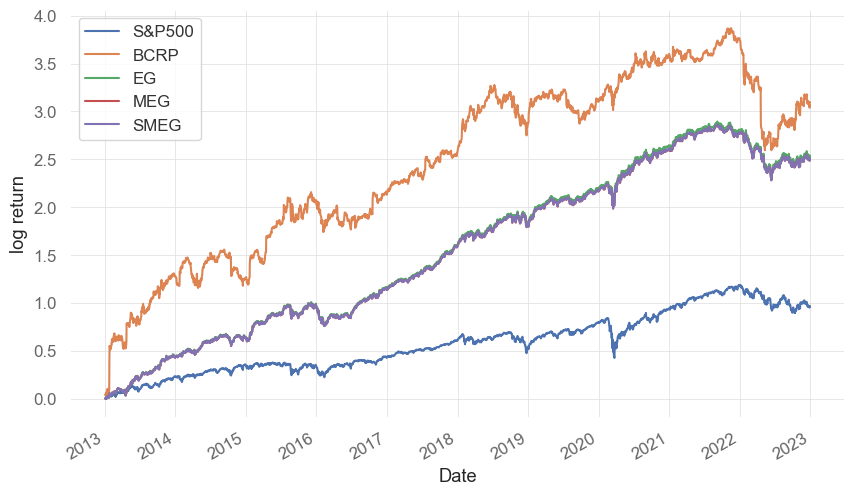

In [140]:
eg = EG(r[:], eg_eta(r), 7)
print(f"The choice of eta in THEROEM I: {eg_eta(r)}")
eg.run()
df['EG'] = np.cumprod(pay_fee_period(r,eg.weight,eg.period))

meg = MEG(r[:], meg_eta(r), meg_alpha(r), 7)
meg.run()
print(f"The choice of eta in THEROEM II: {((8*((((r.shape[1]**2)*np.log(r.shape[1])/(8*r.shape[0]))**(1/4))**2)*np.log(r.shape[1]))/((r.shape[1]**2)*r.shape[0]))**(1/2)}")
df['MEG'] = np.cumprod(pay_fee_period(r,meg.weight,meg.period))

smeg=SMEG(r,7)
smeg.run()
df['SMEG'] = np.cumprod(pay_fee_period(r,smeg.weight,smeg.period))

ax = np.log(df[benchmark_asset_name+['BCRP']+['EG']+['MEG']+['SMEG']]).plot()
ax.set_ylabel("log return")

## Compare the Wealth of All Portfolio Selection

Text(0, 0.5, 'log return')

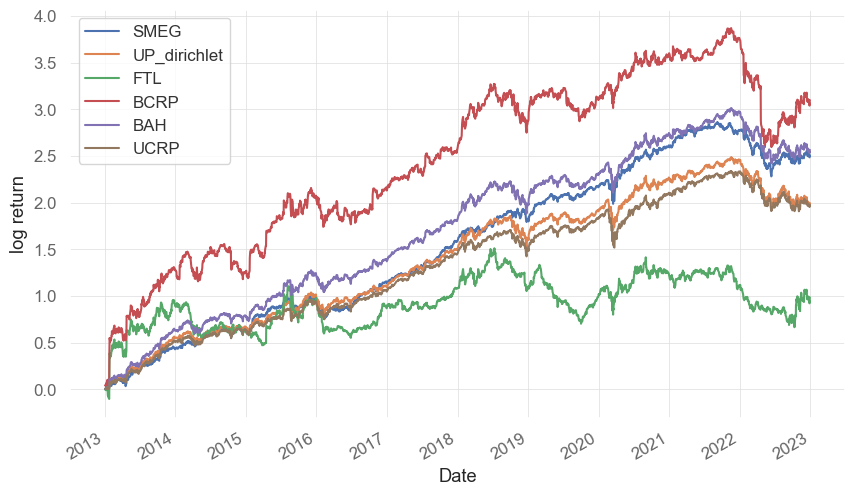

In [141]:
ax = np.log(df[['SMEG','UP_dirichlet','FTL','BCRP','BAH','UCRP']]).plot()
ax.set_ylabel("log return")

In [188]:
Alg_name=['BAH','FTL','UCRP','BCRP','UP_dirichlet','SMEG']

def APY(Alg): #Annual Percentage Yield
    apy=[]
    for alg in Alg:
        apy.append([pow(df[alg][r.shape[0]-1],365/r.shape[0])-1])
    return pd.DataFrame(np.array(apy).transpose(),index=["APY"],columns=Alg_name)

def volatility(Alg):
    v=[]
    for alg in Alg:
        valg=[]
        for t in range(df[Alg].shape[0]-1):
            valg.append((df[alg][t+1]-df[alg][t])/df[alg][t])
        v.append([pd.Series(valg).std()])
    return pd.DataFrame(np.array(v).transpose(),index=["Volatility"],columns=Alg_name)

def DD(Alg):
    mdd=[]
    for alg in Alg:
        related=[]
        related_mul=[]
        related_mul_max=[]
        dd=[]
        for t in range(len(df[alg])-1):
            related.append(df[alg][t+1]/df[alg][t])
            related_mul.append(np.prod(np.array(related)))
            related_mul_max.append(max(related_mul))
        for t in range(df[alg].shape[0]-1):
            dd.append(1-related_mul[t]/related_mul_max[t])
        mdd.append([-max(dd)])
    return pd.DataFrame(np.array(mdd).transpose(),index=["Drawdown"],columns=Alg_name)

def sharpe_ratio(Alg,risk_free_rate=0.0406):
    sr=[]
    annual_returns = []
    for year,group in df[Alg].groupby(df[Alg].index.year):
        start_price = group.iloc[0]
        end_price = group.iloc[-1]
        annual_return = (end_price/start_price-1)
        annual_returns.append(annual_return)
    
    annual_returns=np.array(annual_returns).transpose()
    
    std=[] 
    for alg in Alg:
        related=[]
        for t in range(len(df[alg])-1):
            related.append((df[alg][t+1]-df[alg][t])/df[alg][t])
        std.append(np.std(np.array(related),ddof=1))
        
    for i in range(len(annual_returns)):
        mean=sum(annual_returns[i])/len(annual_returns[i])
        sr.append([(mean-risk_free_rate)/std[i]])

    return pd.DataFrame(np.array(sr).transpose(),index=["Sharpe Ratio"],columns=Alg_name)

def VaR(Alg,confidence_level):#using Historical Simulation Approach
    var=[]
    for alg in Alg:
        related=[]
        for t in range(len(df[alg])-1):
            related.append((df[alg][t+1]-df[alg][t])/df[alg][t])
        related.sort()
        var.append([related[int(np.floor(len(df[alg])*np.percentile(range(len(df[alg])),1-confidence_level)))]])
    return pd.DataFrame(np.array(var).transpose(),index=["VaR"],columns=Alg_name)

def CVaR(Alg,confidence_level):
    cvar=[]
    for alg in Alg:
        related=[]
        sum=0
        for t in range(len(df[alg])-1):
            related.append((df[alg][t+1]-df[alg][t])/df[alg][t])
        related.sort()
        for t in range(int(np.floor(len(df[alg])*np.percentile(range(len(df[alg])),1-confidence_level)))):
            sum+=related[t]
        cvar.append([sum/int(np.floor(len(df[alg])*np.percentile(range(len(df[alg])),1-confidence_level)))])
    return pd.DataFrame(np.array(cvar).transpose(),index=["CVaR"],columns=Alg_name)

df_compare=pd.concat([APY(Alg_name),volatility(Alg_name),DD(Alg_name),sharpe_ratio(Alg_name),VaR(Alg_name,0.99),CVaR(Alg_name,0.99)],axis=0)
df_compare

,BAH,FTL,UCRP,BCRP,UP_dirichlet,SMEG
APY,0.450435,0.153241,0.331994,0.567085,0.335367,0.438859
Volatility,0.015955,0.022859,0.013793,0.027459,0.014765,0.013165
Drawdown,-0.446308,-0.569875,-0.350890,-0.720839,-0.414831,-0.441741
Sharpe Ratio,18.174134,5.804492,14.728218,17.221790,14.502583,20.082852
VaR,-0.005811,-0.009381,-0.004554,-0.010787,-0.005234,-0.004367
CVaR,-0.017672,-0.022757,-0.015274,-0.027269,-0.016691,-0.014275


## Observations

- Both $\text{UP}$ and $\text{EG}$ outperform the benchmark. However, a key consideration is the transaction costs incurred due to frequent rebalancing. Our findings suggest that a rebalancing period of approximately 5-10 days strikes a good balance, minimizing costs while leveraging the benefits of these strategies.

- Regarding $\text{UP}$, accurately calculating the weight vector is computationally intensive. We've found that employing the Monte Carlo method with a sample size of around 10,000 points offers a sufficiently accurate approximation without excessive computation.

- For $\text{EG}$, while we have identified a theoretically optimal parameter for $\eta$, in practice, a higher $\eta$ than this theoretical optimum often yields better returns.

## References

- [R1] AVRIM BLUM, ADAM KALAI, School of Computer Science, Carnegie Mellon University, Pittsburgh, PA 15213, Universal Portfolios With and Without Transaction Costs

- [R2] DAVID P. HELMBOLD, ROBERT E. SCHAPIRE AND YORAM SINGER, AT&T Labs, MANFRED K. WARMUTH, Computer and Information Sciences, University of California, Santa Cruz, ON-LINE PORTFOLIO SELECTION USING MULTIPLICATIVE UPDATES

- [R3] github, Sudeep Raja, Online Portfolio Selection: https://sudeepraja.github.io/OPS1/

- [R4] github, Marigold, Online Portfolio Selection: https://github.com/Marigold/universal-portfolios